In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Utility Functions and tests for them

# Get the closing price on the specified date. If there is no entry for that particular date, it will return the value
# for the previous date when the value is available. The date can be specified either as a datetime or as a string. It is 
# assumed that the date and closing value are in a column called Date and Close respectively
def get_closing_on_date(df,date) :
    
    def inner_get_closing_on_date(df, date, min_date, max_date):
        
        #print("date = ", date,min_date,max_date)
        # Sanity Check of range
        if date > max_date or date < min_date :
            assert False, "get_closing_on_date() called with a date that is outside the range"
            
        filtered_df = df[df.Date == date]
        rows = len(filtered_df)
        if rows == 1 :
            # we found a single record with this data
            return filtered_df.iloc[0].Close
        elif rows == 0 :
            new_date = date - pd.DateOffset(days=1)  # try the previous date. Can also use pd.Timedelta(1, unit='d')
            return inner_get_closing_on_date(df, new_date, min_date, max_date)
        else:
            # this should never happened
            assert False, "get_closing_on_date() found multiple records with the same date"
    
    # call the inner function
    min_date = df.Date.min()
    max_date = df.Date.max()
    d = pd.to_datetime(date)
    return inner_get_closing_on_date(df, d, min_date, max_date)

# Test Data ...
test_data = { "Date" : ["2020 Jan 01", "2019 Dec 31", "2019 Dec 30", "2019 Dec 26", "2019 Dec 24"],
        "Close": [100.0, 200.0, 300.0, 400.0, 500.0]}
test_df = pd.DataFrame(test_data)
test_df['Date'] = pd.to_datetime(test_df['Date']) # reformat the date from string to datetime

# Simple tests ....
assert get_closing_on_date(test_df,"2019-12-24") == 500.0, 'Test Failed for 2019-12-24'
assert get_closing_on_date(test_df, pd.to_datetime("2019-12-26")) == 400.0, 'Test Failed for 2019-12-26'

# Tests for dates where data is missing
assert get_closing_on_date(test_df,"2019-12-25") == 500.0, 'Test Failed for 2019-12-25'
assert get_closing_on_date(test_df, pd.to_datetime("2019-12-29")) == 400.0, 'Test Failed for 2019-12-29'

# Tests for dates that are on the max/min of date range
assert get_closing_on_date(test_df,"2019-12-24") == 500.0, 'Test Failed for 2019-12-24'
assert get_closing_on_date(test_df,"2020-01-01") == 100.0, 'Test Failed for 2019-01-01'

# What happens if the input date is earlier than the earliest date ? 
#get_closing_on_date(test_df,"2019-12-20")


In [3]:
def generate_dates(starting_date,ending_date) :
    d = starting_date
    dates = []
    while d < ending_date:
        dates.append(d)
        d = d + pd.DateOffset(months=1)
    return dates

# Given the index in index_df, return the index value on the 1st of the month for every month
# between starting_date and ending_date. Also give the value of the index number_of_months into
# the future from that date
def index_return(index_df, starting_date, ending_date, number_of_months=12):
    dates = generate_dates(starting_date, ending_date)
    offset = pd.DateOffset(months=number_of_months)
    df = pd.DataFrame({"Date": dates})
    df['Close'] = df['Date'].apply(lambda d : get_closing_on_date(index_df, d))
    df['FutureDate'] = df['Date'].apply(lambda d : d + offset)
    df['FutureClose'] = df['FutureDate'].apply(lambda d : get_closing_on_date(index_df,d))
    df['Gain'] = df['FutureClose'] / df['Close'] * 100.0 - 100.00
    return df


In [4]:
# Load the Index data from a CSV File
def load_index_data(filename):
    df = pd.read_csv(filename,sep=",") 
    df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y') # reformat the date from string to datetime
    df.drop( ['Open', 'High', 'Low'], axis=1, inplace=True)  # remove the columns we don't need
    return df
    

In [5]:
# Returns the number of times a certaiin amount of gain has happened 
def gain_frequency(df):
    # Series that contains the gains
    gains = df.Gain

    # The minimum and maximum %age gains in this data set
    min = gains.min()
    max = gains.max()
    print(min,max)
    
    # Figure out the lowest and max limit in multiples
    min = int(round(min))-2.5
    max = int(round(max))+2.5
    print(min,max)

    # Generate the bins
    bins=list(np.arange(min, max, 1.0))
    #print(list(bins))
    
    tmp_df = pd.cut(gains,bins=bins).value_counts().to_frame().reset_index()
    tmp_df.rename(columns={'Gain':'Count'}, inplace=True)
    tmp_df['Gain'] = tmp_df['index'].apply(lambda x : x.mid)
    tmp_df.sort_values('Gain', ascending=True,inplace=True)
    tmp_df.drop( ['index'], axis=1, inplace=True)
    
    out = tmp_df[['Gain', 'Count']]
    out.reset_index(drop=True,inplace=True)
    return out

In [27]:
# What is the proability that the gain is g percent or less
def prob_min_gain(cdf, g) :
    g = int(g)
    tmp = cdf.copy(deep=True)
    tmp = tmp[tmp.Gain >= g]
    tmp.reset_index(inplace=True)
    return tmp.Probability.iloc[0]
    print(tmp.head())
    

In [28]:
# Returns a Cumulative Distribution (CDF) against the gains ...
def cdf(freq) :
    df = freq.copy(deep=True)
    n = df.Count.sum()
    df['CumCount'] = df.Count.cumsum()
    df['Probability'] = df.CumCount / n
    df.drop(['Count', 'CumCount'], axis=1, inplace=True)
    return df

## Main Analysis starts here ...

Load the NIFTY data, and compute the gains over a 12- and 60- month intervals and store it in nifty12 and nifty60 respectively.

In [29]:
nifty = load_index_data('NIFTY 50_Data.csv')
starting_date = pd.to_datetime('1991-01-01')
ending_date = pd.to_datetime('2014-05-31')
nifty60 = index_return(nifty, starting_date, ending_date,number_of_months=60)
nifty12 = index_return(nifty, starting_date, ending_date,number_of_months=12)
#nifty_monthly.head(10)

In [30]:
nifty60.head()

,Date,Close,FutureDate,FutureClose,Gain
0,1991-01-01,330.86,1996-01-01,908.01,174.439340
1,1991-02-01,324.29,1996-02-01,869.54,168.136544
2,1991-03-01,379.94,1996-03-01,999.47,163.059957
3,1991-04-01,372.70,1996-04-01,994.80,166.917091
4,1991-05-01,389.01,1996-05-01,1137.86,192.501478


## How much am I likely to gain in NIFTY over a period of 5 years ?

-23.560690445797732 516.5799569078774
-26.5 519.5


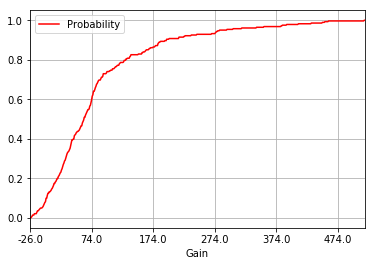

In [31]:
gfreq60 = gain_frequency(nifty60)
gcdf = cdf(gfreq60)
gcdf.plot(x='Gain',y='Probability',color='red')
plt.grid(True)

The y-axis is the probability that the gain over the interval will be x-axis or less. For example, there is a 60% probability that the total gain over a 60 month interval will be 74% or less.

In [32]:
prob_min_gain(gcdf,74)

0.597864768683274

In [33]:
prob_min_gain(gcdf, 0)

0.099644128113879

This means that there is a ~10% chance of losing money (i.e. gain <= 0 ) over a 60 month interval

## How much am I likely to gain with FD over a period of 5 years ?

Here we will assume that the interest rate remains fixed over the 5 years.

In [34]:
annual_interest_rate = 6.5   # express the annual interest rate in percentage
r = annual_interest_rate / 100
end_value = (1+r) ** 5
gain = (end_value - 1) * 100 # Gain expressed as a percentage
gain

37.00866634156246

In [36]:
prob_min_gain(gcdf, gain)

0.33807829181494664

This means there is a 33% chance that over a period of 5 years you will make more money with FD than with NIFTY